# How to extract training and prediction matrices

While the main focus of creating forecasting models is predicting future values, it's also useful to evaluate whether the model is learning from the training data. Predictions on the training data can help with this evaluation.

**Training matrices**

...


**Prediction matrices**

...

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

If the Forecaster contains any transformation or differentiation, it is necessary to revert this transformation to the output matrices of this methods. This is because to train or predict we need the matrices on the transformed scale, so reverse transformation is required to obtain the original scale.

</div>

# TODO: Incluir LINKS EN TODOS LOS FORECASTERS Y EN SHAP

## Libraries and data

In [26]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.direct import ForecasterDirectMultiVariate

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


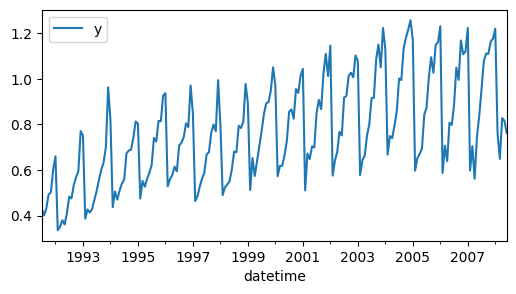

In [27]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data['y'].plot(ax=ax)
ax.legend()
plt.show()

## ForecasterRecursive

In [50]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 5,
                 window_features = window_features
             )

forecaster.fit(y=data['y'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor(random_state=123, verbose=-1) 
Lags: [1 2 3 4 5] 
Window features: ['roll_mean_5', 'roll_sum_5'] 
Window size: 5 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-06 10:27:06 
Last fit date: 2024-11-06 10:27:06 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [29]:
# Create training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(y=data['y'])

In [30]:
# Predictors matrix
# ==============================================================================
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
datetime,,,,,,,
1991-12-01,0.502369,0.492543,0.432159,0.400906,0.429795,0.451554,2.257772
1992-01-01,0.602652,0.502369,0.492543,0.432159,0.400906,0.486126,2.430629
1992-02-01,0.660119,0.602652,0.502369,0.492543,0.432159,0.537968,2.689842


In [31]:
# Target variable matrix
# ==============================================================================
y_train.head(3)

datetime
1991-12-01    0.602652
1992-01-01    0.660119
1992-02-01    0.336220
Freq: MS, Name: y, dtype: float64

We can obtain the training predictions using the `predict` method of the regressor stored inside the forecaster object. By examining the predictions on the training data, analysts can get a better understanding of how the model is performing and make adjustments as necessary.

In [32]:
# Training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressor.predict(X_train)
predictions_training[:4]

array([0.49322601, 0.6376049 , 0.58531495, 0.44962278])

Skforecast provides the `create_predict_X` method to generate the matrices that the forecaster is using to make predictions. This method can be used to gain insight into the specific data manipulations that occur during the prediction process.

In [33]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=5)
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
2008-07-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-08-01,0.865361,0.762137,0.816255,0.827887,0.649435,0.784215,3.921075
2008-09-01,0.878167,0.865361,0.762137,0.816255,0.827887,0.829961,4.149806
2008-10-01,0.806708,0.878167,0.865361,0.762137,0.816255,0.825726,4.128628
2008-11-01,0.873597,0.806708,0.878167,0.865361,0.762137,0.837194,4.185970


In [34]:
# Predict using the internal regressor
# ==============================================================================
predictions = forecaster.regressor.predict(X_predict)
predictions

array([0.86536052, 0.87816664, 0.80670845, 0.87359717, 0.96601636])

## ForecasterDirect

In [35]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterDirect(
                 regressor       = Ridge(random_state=123),
                 steps           = 3,
                 lags            = 5,
                 window_features = window_features
             )

forecaster.fit(y=data['y'])

Two steps are required to extract the training matrices. One to create the entire training matrix and a second to subset the data needed for each model (step).

In [36]:
# Create the whole train matrix
X_train, y_train = forecaster.create_train_X_y(y=data['y'])

# Extract X and y to train the model for step 1
X_train_1, y_train_1 = forecaster.filter_train_X_y_for_step(
                           step          = 1,
                           X_train       = X_train,
                           y_train       = y_train,
                           remove_suffix = False
                       )

X_train_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
datetime,,,,,,,
1991-12-01,0.502369,0.492543,0.432159,0.400906,0.429795,0.451554,2.257772
1992-01-01,0.602652,0.502369,0.492543,0.432159,0.400906,0.486126,2.430629
1992-02-01,0.660119,0.602652,0.502369,0.492543,0.432159,0.537968,2.689842
1992-03-01,0.336220,0.660119,0.602652,0.502369,0.492543,0.518781,2.593903


In [37]:
# Internal regressors {step: regressor}
# ==============================================================================
forecaster.regressors_

{1: Ridge(random_state=123),
 2: Ridge(random_state=123),
 3: Ridge(random_state=123)}

In [38]:
# Step 1 training predictions using the internal regressor
# ==============================================================================
predictions_training = forecaster.regressors_[1].predict(X_train_1)
predictions_training[:4]

array([0.5960254 , 0.6592509 , 0.70209408, 0.50312286])

In [39]:
# Create input matrix for predict method
# ==============================================================================
X_predict = forecaster.create_predict_X(steps=3)
X_predict

,lag_1,lag_2,lag_3,lag_4,lag_5,roll_mean_5,roll_sum_5
2008-07-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-08-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536
2008-09-01,0.762137,0.816255,0.827887,0.649435,0.761822,0.763507,3.817536


In [40]:
# Step 1 predictions using the internal regressor
# ==============================================================================
predictions = forecaster.regressors_[1].predict(X_predict)
predictions

array([0.78198225, 0.78198225, 0.78198225])

## Creating matrices when including transformations

When the Forecaster includes transformation and/or differentiation, the output matrices of these methods will be created in the transformed scale. As a result, any predictions generated using these matrices will also be in the transformed scale. Some additional steps are needed to revert these transformations.

In [ ]:
# TODO: Include LINKS TO TRANSFORMATION AND DIFFERENTATION user guides

In [42]:
# Create and fit forecaster
# ==============================================================================
window_features = RollingFeatures(
                      stats        = ['mean', 'sum'],
                      window_sizes = [5, 5]
                  )

forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 5,
                 window_features = window_features,
                 transformer_y   = StandardScaler(),
                 differentiation = 1
             )

forecaster.fit(y=data['y'])

# TODO: INclude new untransformation method

In [ ]:
# Training predictions with transformations
# ==============================================================================
X_train_transformed, y_train_transformed = forecaster.create_train_X_y(y=data['y'])

# Training predictions using the internal regressor
predictions_transformed = forecaster.regressor.predict(X_train_transformed)

# Revert differentiation (only if differentiation is not None)
differentiator = deepcopy(forecaster.differentiator)
differentiator.initial_values = [
    data['y'].iloc[forecaster.window_size - forecaster.differentiation]
]
predictions_transformed = differentiator.inverse_transform(predictions_transformed)

# Revert transformation (only if transformer_y is not None)
predictions_training = forecaster.transformer_y.inverse_transform(predictions_transformed.reshape(-1, 1))
predictions_training.ravel()[:4]

array([0.9034915 , 0.85556571, 0.6605722 , 0.70044667])

In [51]:
data['y'].iloc[forecaster.window_size - forecaster.differentiation]

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
y = [0, 1, 2, 3] # serie original
y_train = [1, 2, 3] # sin window_size posiciones al inicio
y_train_pred = [1.1, 2.1, 3.1]

y_train_diff = [1, 1]
y_train_pred_diff = [1.1, 1.1]

initial_value = [0] # Primer valor de serie original
y_train_intial_value = [1] # después de window size
y_train_undiff = [1, 2, 3]
y_train_pred_undiff = [1.1, 2.1, 3.2]